<a href="https://colab.research.google.com/github/MTracchia/Laboratorio-de-Datos/blob/main/Clases/An%C3%A1lisis%20de%20t%C3%B3picos/T%C3%B3picos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de tópicos

En esta notebook vamos a descomponer en tópicos un conjunto de textos. La descomposición en tópicos pueden pensarla a la vez como un proceso de reducción dimensional, al describir los datos en el espacio de tópicos en vez del espacio original de features), o como un proceso de *clustering*, al agrupar los textos en dichos tópicos.

Vamos a aplicar dos algoritmos (NMF y LDA) sobre el dataset de letras de tango visto en clases anteriores.

In [ ]:
# Importamos las librerías habituales
import pandas as pd 
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pylab as plt
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importamos nltk para extraer stopwords 
import nltk 
nltk.download('stopwords')

# Librería para hacer wordclouds
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Objetos de sklearn para hacer tópicos
from sklearn.feature_extraction.text import CountVectorizer # Contador de frecuencia
from sklearn.feature_extraction.text import TfidfTransformer # Creador de tf-idf

# Algoritmos de descomposición de tópicos
from sklearn.decomposition import NMF 
from sklearn.decomposition import LatentDirichletAllocation

Cargamos el dataset con el que vamos a trabajar desde la carpeta de la materia. Vamos a utilizar el dataset de la clase de sentiment sobre letras de distintos ritmos musicales:

In [ ]:
# Path de nuestro dataset
filename = '/content/drive/My Drive/LaboDatos2021/todo_tangos.csv'

# Carga del dataset
df = pd.read_csv(filename)

# Vemos las primeras filas 
df.head()

,url,titulo,ritmo,autor_letra,autor_musica,letra,ano
0,https://www.todotango.com/musica/tema/130/A-ba...,A bailar,Tango,Homero Expósito,Domingo Federico,¡A bailar a bailar que la orquesta se va! Sobr...,1943.0
1,https://www.todotango.com/musica/tema/7866/A-b...,A bailar el tango,Tango,Leopoldo Díaz Vélez,Leopoldo Díaz Vélez,Este tango nació para bailarse y así hamacarse...,1962.0
2,https://www.todotango.com/musica/tema/3647/A-B...,A Beba Bidart,Poemalunfardo,Alberto Uemura,NaN,Nació en la calle Quito entre Boedo y Colombre...,NaN
3,https://www.todotango.com/musica/tema/2864/A-b...,A bordo de mis zapatos,Milonga,Eugenio Majul,César Isella,Caminé todas las calles de Buenos Aires y es c...,NaN
4,https://www.todotango.com/musica/tema/3843/A-B...,A Buenos Aires,Milonga,Edmundo Rivero,Edmundo Rivero,En tu baraje gringo ciudad mía vas perdiendo t...,NaN


Vamos a seleccionar todas las canciones identificadas en el género "tango" y quedarnos con solo las filas que tengan información de las letras:

In [ ]:
# Nos quedamos con solo las letras de tango que no tengan un Nan en la columna letra
df = df[df['ritmo'] == "Tango"].dropna(subset = ['letra']).copy()

# Reseteamos el índice
df.reset_index(drop = True, inplace = True)

# Vemos las primeras filas 
df.head()

,url,titulo,ritmo,autor_letra,autor_musica,letra,ano
0,https://www.todotango.com/musica/tema/130/A-ba...,A bailar,Tango,Homero Expósito,Domingo Federico,¡A bailar a bailar que la orquesta se va! Sobr...,1943.0
1,https://www.todotango.com/musica/tema/7866/A-b...,A bailar el tango,Tango,Leopoldo Díaz Vélez,Leopoldo Díaz Vélez,Este tango nació para bailarse y así hamacarse...,1962.0
2,https://www.todotango.com/musica/tema/6354/A-c...,A cara limpia,Tango,Nolo López,Anselmo Aieta,No te demores que se hace tarde ponete pronto ...,NaN
3,https://www.todotango.com/musica/tema/6455/A-c...,A cara o cruz,Tango,Agustín Irusta,Agustín Irusta,A cara o cruz le dije un día y a cara cruz jug...,NaN
4,https://www.todotango.com/musica/tema/33/A-Cat...,A Cátulo Castillo,Tango,Eladia Blázquez,Eladia Blázquez,Tu muerte fue una tarde muy cálida de Octubre ...,NaN


### Construcción de la matriz documentos-términos

Vamos a construir esta matriz con valorización tf-idf, es decir, además de la frecuencia del término vamos a ponderar la especificidad. 
Esto lo hacemos en dos pasos: primero, describimos nuestros datos mediante frecuencia de términos; luego, le agregamos la valorización de la especificidad. 
Vamos además a remover las *stopwords* obtenidas de *nltk*.

In [ ]:
# Lista de stopwords
stopwords = nltk.corpus.stopwords.words('spanish')

# Creamos el objeto contador de palabras, pidiéndole que remueve
# las stopwords, los términos que aparecen en un único documento (min_df)
# y los términos que aparecen en más del 70% de los documentos (max_df).
# Esto es para eliminar palabras raras (o errores de tipeo) y 
# términos que seguramente son stopwords no incluídos en la lista
count = CountVectorizer(min_df = 2, max_df = 0.70, stop_words = stopwords)

# Ajustamos con los datos. Acá especificamente creamos una matriz documentos-términos
x_count = count.fit_transform(df['letra'])

# Dimensions de la matriz doc-tér
print(x_count.shape)

(3981, 16661)


Podemos tranquilamente trabajar sobre la matriz de documentos descritos a través de la frecuencia de las palabras o bien, como es habitual, ponderar la especificidad de los términos mediante tf-idf. Esto lo hacemos de la siguiente manera:

In [ ]:
# Creamos el objeto tf-idf. Le decimos además que devuelva los
# vectores documento con norma euclídea igual a 1 (norm = 'l2')
tfidf = TfidfTransformer(norm = 'l2')

# Creamos la matriz tf-idf a partir de la matriz de frecuencias
x_tfidf = tfidf.fit_transform(x_count)

### Aplicación de NMF sobre el corpus

Vamos a buscar los tópicos en nuestro corpus de textos a través de la descomposición en matrices no-negativas. Elijamos por ejemplo 5 tópicos:

In [ ]:
# Elijamos la cantidad de tópicos
n_components = 5

# Construímos el objeto NMF con los tópicos indicados 
nmf = NMF(n_components = n_components)

# Aplicamos sobre nuestros datos
x_nmf = nmf.fit_transform(x_tfidf)

# Dimensión de la matriz transformada
print(x_nmf.shape)

(3981, 5)


Veamos qué significa cada tópico. Lo que hay que indentificar es cuáles son los índices con mayor peso en cada componente y a qué término le corresponde. Para ello primero vamos a invertir el diccionario de vocabulario (para obtener otro del estilo "índice: término") y ordenar los índices de mayor a menor en cada componente:

In [ ]:
# Objeto índice: término de nuestro vocabulario
vocabulary = {item: key for key, item in count.vocabulary_.items()}

# Para cada componente
for n in range(n_components):

  # Ordenamos una lista del largo de nuestro vocabulario según el peso en cada componente y nos quedamos con los primeros 10
  list_sorted = sorted(range(nmf.components_.shape[1]), reverse = True, key = lambda x: nmf.components_[n][x])[:10]

  # Printeamos los términos asociados a los valores más grande de cada una de las componentes
  print(', '.join([vocabulary[i] for i in list_sorted]))
  print('\n')

amor, corazón, quiero, vida, si, dolor, alma, sé, querer, cariño


tango, bandoneón, arrabal, compás, bailar, emoción, notas, canción, corazón, alma


vos, si, pa, sos, bien, tenés, vas, sé, querés, hoy


noche, voz, adiós, tiempo, barrio, sol, luz, dos, cielo, luna


aires, buenos, ciudad, calles, cada, tangos, noches, aire, gardel, vos




Para que sea más fácil visualizar, armemos wordclouds, poniendole el peso dado por el algoritmo de NMF:

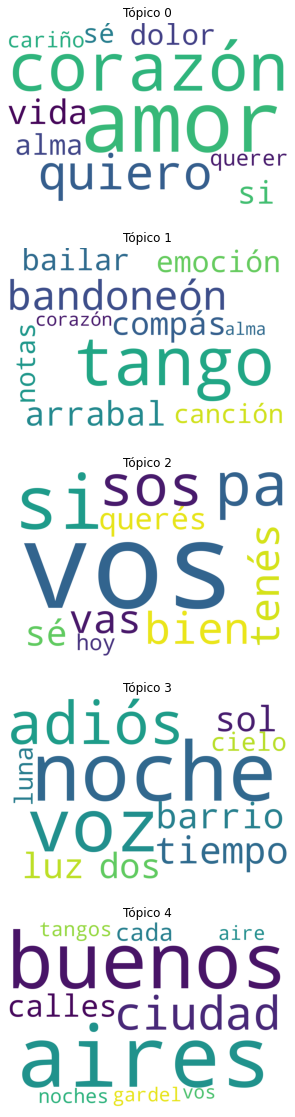

In [ ]:
# WordClouds
wc_atributos = {'height' : 800,
                'width' : 1200,
                'background_color' : 'white',
                'max_words' : 20
                } # Defino los parámetros que les voy a pasar a los wordclouds

# Creo la figura
fig, axs = plt.subplots(n_components, figsize = (6,20))

# Recorro para todas las componentes
for n in range(n_components):

  # 10 términos más pesados
  list_sorted = sorted(range(len(vocabulary)), reverse = True, key = lambda x: nmf.components_[n][x])[:10]

  # Diccionario término: peso
  comp_dict = {vocabulary[i]: nmf.components_[n][i] for i in list_sorted}

  # Creo el wordlcoud
  wc = WordCloud(**wc_atributos # De esta forma, le estoy diciendo a la función que expanda el diccionario de atributos de forma tal de que entienda lo que quiero que haga
                 ).generate_from_frequencies(comp_dict)

  axs[n].set_title('Tópico {}'.format(n))
  axs[n].imshow(wc)
  axs[n].axis('off')

plt.show()

#### Evolución de los tópicos

Algo que podemos hacer al identificar los tópicos es ver cómo evolucionan en el tiempo, es decir, si hay tópicos dominantes en determinados períodos. Antes de hacer esto, normalizemos los vectores documentos en el espacio de tópicos para interpretarlos como una distribución:

In [ ]:
# Normalizador
from sklearn.preprocessing import Normalizer 

# Creamos un objeto para normalizar a que la suma dé 1
norm = Normalizer('l1')

# Sobreescribimos sobre la matriz de documentos-tópicos
x_nmf = norm.fit_transform(x_nmf)

# Guardemos en el dataframe esta información
for n in range(n_components):
  df['nmf_comp{}'.format(n)] = x_nmf[:,n]

df.head()

,url,titulo,ritmo,autor_letra,autor_musica,letra,ano,nmf_comp0,nmf_comp1,nmf_comp2,nmf_comp3,nmf_comp4
0,https://www.todotango.com/musica/tema/130/A-ba...,A bailar,Tango,Homero Expósito,Domingo Federico,¡A bailar a bailar que la orquesta se va! Sobr...,1943.0,0.000000,0.895235,0.000000,0.104765,0.000000
1,https://www.todotango.com/musica/tema/7866/A-b...,A bailar el tango,Tango,Leopoldo Díaz Vélez,Leopoldo Díaz Vélez,Este tango nació para bailarse y así hamacarse...,1962.0,0.000000,0.981445,0.018555,0.000000,0.000000
2,https://www.todotango.com/musica/tema/6354/A-c...,A cara limpia,Tango,Nolo López,Anselmo Aieta,No te demores que se hace tarde ponete pronto ...,NaN,0.332893,0.000000,0.604714,0.041847,0.020546
3,https://www.todotango.com/musica/tema/6455/A-c...,A cara o cruz,Tango,Agustín Irusta,Agustín Irusta,A cara o cruz le dije un día y a cara cruz jug...,NaN,0.354441,0.000000,0.238834,0.406725,0.000000
4,https://www.todotango.com/musica/tema/33/A-Cat...,A Cátulo Castillo,Tango,Eladia Blázquez,Eladia Blázquez,Tu muerte fue una tarde muy cálida de Octubre ...,NaN,0.000000,0.175249,0.155450,0.648185,0.021117


Para tener una buena resolución de las series temporales, agrupemos los datos por década, enfocándonos solo en el siglo XX:

In [ ]:
# Tomamos solo datos del siglo XX
df_tango_sigloXX = df[(df['ano'] >= 1900) & (df['ano'] < 2000)].copy()

# Creamos una columna que sea la década a la cual pertenece
df_tango_sigloXX['decada'] = ((df_tango_sigloXX['ano'] % 100) // 10) * 10

# Limpiamos los datos sin información sobre la década
df_tango_sigloXX.dropna(subset = ['decada'], inplace = True)

# Reseteamos el índice
df_tango_sigloXX.reset_index(drop = True, inplace = True)

df_tango_sigloXX.head()

,url,titulo,ritmo,autor_letra,autor_musica,letra,ano,nmf_comp0,nmf_comp1,nmf_comp2,nmf_comp3,nmf_comp4,decada
0,https://www.todotango.com/musica/tema/130/A-ba...,A bailar,Tango,Homero Expósito,Domingo Federico,¡A bailar a bailar que la orquesta se va! Sobr...,1943.0,0.0,0.895235,0.000000,0.104765,0.000000,40.0
1,https://www.todotango.com/musica/tema/7866/A-b...,A bailar el tango,Tango,Leopoldo Díaz Vélez,Leopoldo Díaz Vélez,Este tango nació para bailarse y así hamacarse...,1962.0,0.0,0.981445,0.018555,0.000000,0.000000,60.0
2,https://www.todotango.com/musica/tema/2304/A-c...,A contramano,Tango,Juan Andrés Caruso,Luis Teisseire,Mire amigo que va a contramano no le hable a e...,1928.0,0.0,0.050242,0.772771,0.176986,0.000000,20.0
3,https://www.todotango.com/musica/tema/8733/A-D...,A Don Javier,Tango,Roberto Vidal,Roberto Zanoni,Las notas bailan detrás del pentagrama la mano...,1984.0,0.0,0.620477,0.000000,0.364344,0.015178,80.0
4,https://www.todotango.com/musica/tema/6154/A-e...,A escuchar tangos,Tango,Carlos Lagos,Carlos Lagos,Para el sábado a la noche decidimos la salida ...,1999.0,0.0,0.146530,0.336963,0.420490,0.096018,90.0


Para ver la evolución, promediemos las distribución correspondientes a cada década:

In [ ]:
df_decada = df_tango_sigloXX.groupby('decada').mean()

# Inspeccionemoslo
df_decada

,ano,nmf_comp0,nmf_comp1,nmf_comp2,nmf_comp3,nmf_comp4
decada,,,,,,
0.0,1905.571429,0.189928,0.151052,0.349745,0.247046,0.062229
10.0,1914.789474,0.252673,0.166085,0.437850,0.110629,0.032763
20.0,1926.190476,0.286320,0.100282,0.349712,0.246054,0.017633
30.0,1933.787097,0.333292,0.049308,0.319802,0.271399,0.026199
40.0,1943.871951,0.324117,0.137705,0.128196,0.382888,0.027093
50.0,1954.642276,0.340907,0.143028,0.204113,0.264277,0.047675
60.0,1964.581818,0.319914,0.101046,0.199095,0.260372,0.119573
70.0,1974.812500,0.169372,0.060490,0.309823,0.344999,0.115315
80.0,1984.750000,0.194079,0.063881,0.234258,0.405651,0.102131


Grafiquemos la evolución:

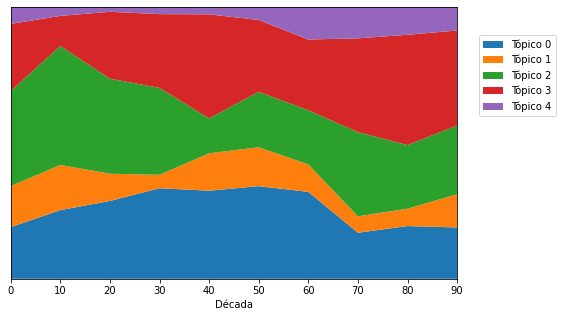

In [ ]:
# El eje x es la década
x = df_decada.index

# El eje y son las distribuciones
y = df_decada[['nmf_comp{}'.format(i) for i in range(n_components)]].to_numpy()

plt.figure(figsize = (8,5))
plt.stackplot(x, y.T) # Stackplot: sirve para graficar distribuciones
plt.xlim([0, 90])
plt.ylim([0, 1.00])
plt.yticks([])
plt.xlabel('Década')
plt.legend(['Tópico {}'.format(i) for i in range(n_components)], loc = (1.05, 0.60))
plt.show()

Podemos jugar con la cantidad de tópicos (y editar las stopwords y demases para tener tópicos más definidos) y ver cómo cambia este gráfico.

### Tópicos con LDA

Latent Dirichlet Allocation (LDA) es el otro algoritmo de detección de tópicos muy utilizado, basado en modelos probabilísticos, un enfoque radicalmente distinto a lo observado para LSA y NMF. 
Sin embargo, la salida es muy similar a este último: obtenemos documentos descritos como distribuciones en el espacio de tópicos y los tópicos son a su vez distruciones en el espacio de términos (con NMF también podíamos normalizar estos vectores e interpretar de la misma manera).

Veamos si devuelve tópicos similares a NMF:

In [ ]:
# Creamos el objeto LDA 
lda = LatentDirichletAllocation(n_components = n_components, max_iter = 25)

In [ ]:
# Ajustamos con los datos. LDA se suele aplicar sobre la matriz de documentos 
# y frecuencia de términos 
x_lda = lda.fit_transform(x_count)

# Dimensión de la matriz transformada
print(x_lda.shape)

(3981, 5)


Interpretación de los tópicos:

In [ ]:
# Para cada componente
for n in range(n_components):

  # Ordenamos una lista del largo de nuestro vocabulario según el peso en cada componente y nos quedamos con los primeros 10
  list_sorted = sorted(range(lda.components_.shape[1]), reverse = True, key = lambda x: lda.components_[n][x])[:10]

  # Printeamos los términos asociados a los valores más grande de cada una de las componentes
  print(', '.join([vocabulary[i] for i in list_sorted]))
  print('\n')

pa, si, vos, sos, bien, hoy, tenés, vida, gran, tan


tango, barrio, bandoneón, viejo, corazón, buenos, arrabal, tiempo, noche, voz


luna, noche, aires, buenos, siempre, sol, ciudad, calle, va, piel


amor, corazón, vida, dolor, alma, si, hoy, quiero, tan, noche


si, vos, vida, sé, hoy, quiero, hombre, así, pa, tan




Wordclouds:

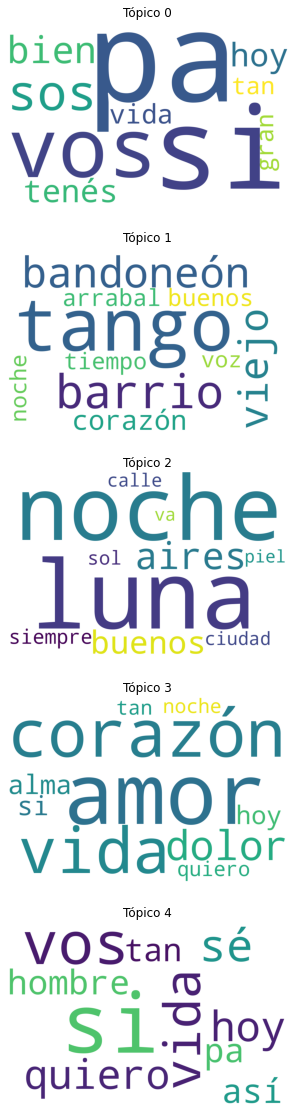

In [ ]:
# WordClouds
wc_atributos = {'height' : 800,
                'width' : 1200,
                'background_color' : 'white',
                'max_words' : 20
                } # Defino los parámetros que les voy a pasar a los wordclouds

# Creo la figura
fig, axs = plt.subplots(n_components, figsize = (6,20))

# Recorro para todas las componentes
for n in range(n_components):

  # 10 términos más pesados
  list_sorted = sorted(range(len(vocabulary)), reverse = True, key = lambda x: lda.components_[n][x])[:10]

  # Diccionario término: peso
  comp_dict = {vocabulary[i]: lda.components_[n][i] for i in list_sorted}

  # Creo el wordlcoud
  wc = WordCloud(**wc_atributos # De esta forma, le estoy diciendo a la función que expanda el diccionario de atributos de forma tal de que entienda lo que quiero que haga
                 ).generate_from_frequencies(comp_dict)

  axs[n].set_title('Tópico {}'.format(n))
  axs[n].imshow(wc)
  axs[n].axis('off')

plt.show()

Dado que los tópicos no suelen ser los mismos y además, aunque fueran similares, tampoco tienen que respetar el mismo ordenamiento, podemos ver si hay algún mapeo entre un algoritmo y otro. Para ello armamos una matriz de confusión con las etiquetas predichas por cada algoritmo (definimos como etiqueta de un documento al tópico más probable):

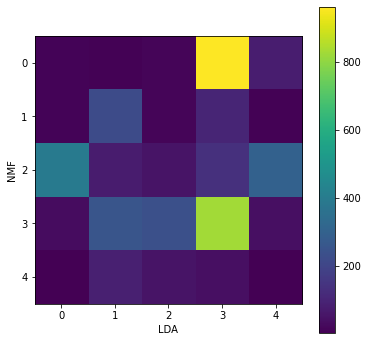

In [ ]:
from sklearn.metrics import confusion_matrix

# Tomamos la etiqueta más probable para cada algoritmo
nmf_labels = np.argmax(x_nmf, axis = 1)

lda_labels = np.argmax(x_lda, axis = 1)

# Creamos la matriz de confusión
cm = confusion_matrix(nmf_labels, lda_labels)

# Graficamos la matriz
plt.figure(figsize = (6,6))
plt.imshow(cm)
plt.colorbar()
plt.xlabel('LDA')
plt.ylabel('NMF')
plt.show()

### Cosas para llevarse, cosas para hacer 

NMF y LDA son dos algoritmos muy utilizados en la detección de tópicos. La salida de ambos es a fines prácticos la misma: vectores que podemos interpretar como distribuciones en el espacio de tópicos y en el espacio de términos. 

Más allá de lo bueno o malo que sean estos algortimos, la definición de los tópicos va a depender gran parte del corpus con el que trabajemos.
Muchas veces para forzar la emergencia de estas estructuras (más allá de forzarlas, quizás encontrarlas debajo del ruido) podemos jugar con:
- stopwords: las que usamos son suficientes? hay términos que aparecen en la definición de los tópicos que tal vez no son informativos y nos meten ruido? Podemos iterativamente actualizar la lista de stopwords para eliminar el clustering de documentos debido a palabras poco informativas.
- además de jugar con las stopwords podemos aprovechar los parámetros *min_df* y *max_df*, que nos van marcando un nivel de resolución de los tópicos que encontremos (por ejemplo, si ponemos max_df = 200, eliminando términos que aparezcan en más de 200 documentos, podríamos estar forzando a la emergencia de tópicos de menos de 200 documentos).

Pueden jugar con los distintos parámetros vistos a fin de encontrar tópicos más definidos.